---
## Step 0: Load The Data

# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Load the Training Data, and the Validation Set

In [21]:
# Load pickled data
import pickle
import os
import cv2

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

Sizes_train = train['sizes']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [22]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

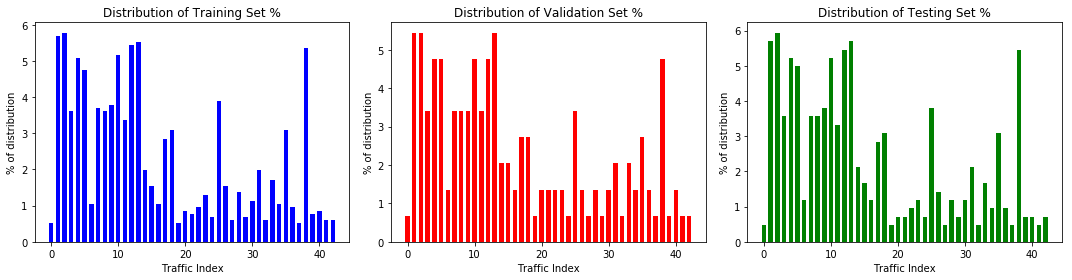

In [46]:
### Data exploration visualization code

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 4))

#counts of each unique sign
counts_train = np.unique(y_train,return_counts = True)
counts_valid = np.unique(y_valid,return_counts = True)
counts_test  = np.unique(y_test,return_counts = True)

#convert to numpy array
counts_train_arr = np.array(counts_train)
counts_valid_arr = np.array(counts_valid)
counts_test_arr  = np.array(counts_test)

#distribution of training, validation and testing sets
distrib_train = (counts_train_arr/n_train) * 100 
distrib_valid = (counts_valid_arr/n_validation) * 100
distrib_test  = (counts_test_arr/n_test) * 100

ax0.bar(counts_train[0],distrib_train[1], width, color="blue")
ax1.bar(counts_valid[0],distrib_valid[1], width, color="red")
ax2.bar(counts_test[0],distrib_test[1], width, color="green")

ax0.set_title('Distribution of Training Set %')
ax1.set_title('Distribution of Validation Set %')
ax2.set_title('Distribution of Testing Set %')

ax0.set_xlabel('Traffic Index')
ax1.set_xlabel('Traffic Index')
ax2.set_xlabel('Traffic Index')

ax0.set_ylabel('% of distribution')
ax1.set_ylabel('% of distribution')
ax2.set_ylabel('% of distribution')

fig.tight_layout()
plt.show()


----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization and grayscale)

In [77]:
#Shuffle the images
from sklearn.utils import shuffle

# Shuffle the images 
X_train, y_train = shuffle(X_train, y_train)

35


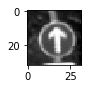

In [78]:
import cv2
import numpy as np

def GrayscaleImage(pixel_data):
    grayscaled_image = cv2.cvtColor(pixel_data, cv2.COLOR_RGB2GRAY)        
    grayscaled_image = grayscaled_image.reshape(32,32,1)
    return grayscaled_image

def CreateGrayscaleImageArray(X_data):
    X_data = np.array([GrayscaleImage(X_data[i]) for i in range(len(X_data))])
    return X_data

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

#Grayscale the training, validation and testing sets
X_train = CreateGrayscaleImageArray(X_train)
X_valid = CreateGrayscaleImageArray(X_valid)
X_test  = CreateGrayscaleImageArray(X_test)

#Print a random image
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(y_train[index])

In [79]:
import numpy as np
#Normalize the training, validation & testing sets

X_train = (X_train - 128.0)/128.0
X_valid = (X_valid - 128.0)/128.0
X_test  = (X_test  - 128.0)/128.0

Normalization complete
(32, 32, 1)


### Setup TensorFlow

In [8]:
import tensorflow as tf

EPOCHS = 50
BATCH_SIZE = 128

### Model Architecture

In [9]:
from tensorflow.contrib.layers import flatten

def TrafficClassifierNet(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x24.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 24), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(24))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1   = tf.nn.relu(conv1)
    #conv1   = tf.nn.dropout(conv1,keep_prob)
    
    # Layer 2: Pooling. Input = 28x28x24. Output = 14x14x24.
    maxp2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #maxp2 = tf.nn.dropout(maxp2,keep_prob)
    
    # Layer 3: Convolutional. Input = 14x14x24. Output = 10x10x48.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 24, 48), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(48))
    conv3   = tf.nn.conv2d(maxp2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3   = tf.nn.relu(conv3)
    #conv3   = tf.nn.dropout(conv3,keep_prob)
    
    # Layer 4: Pooling. Input = 10x10x48. Output = 5x5x48.
    maxp4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #maxp4 = tf.nn.dropout(maxp4,keep_prob)

    # SOLUTION: Flatten. Input = 5x5x48. Output = 1200.
    flat5   = flatten(maxp4)
    
    # Layer 5: Fully Connected. Input = 1200. Output = 480.
    fc5_W = tf.Variable(tf.truncated_normal(shape=(1200, 480), mean = mu, stddev = sigma))
    fc5_b = tf.Variable(tf.zeros(480))
    fc5   = tf.matmul(flat5, fc5_W) + fc5_b
    fc5    = tf.nn.relu(fc5)
    #fc5    = tf.nn.dropout(fc5,keep_prob)
    
    # Layer 6: Fully Connected. Input = 480. Output = 240.
    fc6_W  = tf.Variable(tf.truncated_normal(shape=(480, 240), mean = mu, stddev = sigma))
    fc6_b  = tf.Variable(tf.zeros(240))
    fc6    = tf.matmul(fc5, fc6_W) + fc6_b    
    fc6    = tf.nn.relu(fc6)
    #fc6    = tf.nn.dropout(fc6,keep_prob)
    
    # Layer 7: Fully Connected. Input = 240. Output = 43.
    fc7_W  = tf.Variable(tf.truncated_normal(shape=(240, 43), mean = mu, stddev = sigma))
    fc7_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc6, fc7_W) + fc7_b

    return logits

## Features and Labels

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.


In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

keep_prob = tf.placeholder(tf.float32)


### Training Pipeline


In [11]:
rate = 0.001

logits = TrafficClassifierNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluation of the loss and accuracy of the model for the German Traffic Dataset.

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")


Training...

EPOCH 1 ...
Validation Accuracy = 0.865

EPOCH 2 ...
Validation Accuracy = 0.902

EPOCH 3 ...
Validation Accuracy = 0.922

EPOCH 4 ...
Validation Accuracy = 0.921

EPOCH 5 ...
Validation Accuracy = 0.920

EPOCH 6 ...
Validation Accuracy = 0.917

EPOCH 7 ...
Validation Accuracy = 0.928

EPOCH 8 ...
Validation Accuracy = 0.934

EPOCH 9 ...
Validation Accuracy = 0.936

EPOCH 10 ...
Validation Accuracy = 0.936

EPOCH 11 ...
Validation Accuracy = 0.935

EPOCH 12 ...
Validation Accuracy = 0.937

EPOCH 13 ...
Validation Accuracy = 0.936

EPOCH 14 ...
Validation Accuracy = 0.922

EPOCH 15 ...
Validation Accuracy = 0.943

EPOCH 16 ...
Validation Accuracy = 0.936

EPOCH 17 ...
Validation Accuracy = 0.941

EPOCH 18 ...
Validation Accuracy = 0.953

EPOCH 19 ...
Validation Accuracy = 0.950

EPOCH 20 ...
Validation Accuracy = 0.959

EPOCH 21 ...
Validation Accuracy = 0.941

EPOCH 22 ...
Validation Accuracy = 0.941

EPOCH 23 ...
Validation Accuracy = 0.936

EPOCH 24 ...
Validation Accura

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

16


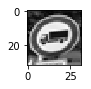

In [27]:
### Load the images and plot them here.
import cv2
import numpy as np

# Load the examples images and the mappings found on the internet
traffic_sign_example_images   = ['0.png','1.png','2.png','3.png','4.png','5.png','6.png','7.png','8.png']
traffic_sign_example_mappings = [12,33,13,17,4,1,28,35,16]

image_array = []

for i in range(0, len(traffic_sign_example_images)):
    test_image = cv2.imread('Traffic-Sign-Examples/' + traffic_sign_example_images[i])
    image_array.append(test_image)

# Grayscale the example
X_test_images = CreateGrayscaleImageArray(image_array)

# Output a random image
index = random.randint(0, len(X_test_images)-1)
image = X_test_images[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(traffic_sign_example_mappings[index])

### Predict the Sign Type for Each Image

In [80]:
#preprocess - normalize the example images
test_images_grayscaled = (X_test_images - 128.0)/128.0

In [35]:
# Class used to save and/or restore Tensor Variables
saver = tf.train.Saver()
prediction = tf.argmax(logits, 1)

with tf.Session() as sess:
    # Load the weights and bias
    saver.restore(sess, './lenet')
    predicted_index = sess.run(prediction,feed_dict={x: test_images_grayscaled, keep_prob:1.0})

for i in range(len(test_images_grayscaled)):
    print("Image {} index = {}, predicted index = {}".format(i+1, traffic_sign_example_mappings[i], predicted_index[i]))


Image 1 index = 12, predicted index = 12
Image 2 index = 33, predicted index = 33
Image 3 index = 13, predicted index = 13
Image 4 index = 17, predicted index = 17
Image 5 index = 4, predicted index = 4
Image 6 index = 1, predicted index = 1
Image 7 index = 28, predicted index = 28
Image 8 index = 35, predicted index = 35
Image 9 index = 16, predicted index = 16


### Analyze Performance

In [38]:
### Calculate the accuracy for these 5 new images. 

with tf.Session() as sess:
    # Load the weights and bias
    saver.restore(sess, './lenet')
    validation_accuracy_percentage = evaluate(X_test_images, traffic_sign_example_mappings) * 100

print("The accuracy on the example images from the internet is {:.1f} %".format(validation_accuracy_percentage))


The accuracy on the example images from the internet is 100.0 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [61]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

softmax_probabilities = tf.nn.softmax(logits)
top_five_probs = tf.nn.top_k(softmax_probabilities, k=5)

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    top_five_probs_out = sess.run(top_five_probs, feed_dict={x: test_images_grayscaled, keep_prob:1.0})

#print(top_five_probs_out)

for i in range(len(test_images_grayscaled)):
    print('Image {}, Real Index = {}, top 5 softmax probabilites:'.format(i+1,traffic_sign_example_mappings[i]))
    
    for j in range(5):
        print('\t Index = {}, Probability = {}'.format(top_five_probs_out.indices[i][j], top_five_probs_out.values[i][j]))




Image 1, Real Index = 12, top 5 softmax probabilites:
	 Index = 12, Probability = 1.0
	 Index = 40, Probability = 9.179338039945316e-34
	 Index = 41, Probability = 2.9976758984899175e-34
	 Index = 0, Probability = 0.0
	 Index = 1, Probability = 0.0
Image 2, Real Index = 33, top 5 softmax probabilites:
	 Index = 33, Probability = 1.0
	 Index = 4, Probability = 1.0280932299210515e-23
	 Index = 25, Probability = 1.7850381541195987e-25
	 Index = 19, Probability = 8.479694516623654e-26
	 Index = 11, Probability = 4.2981527073738104e-26
Image 3, Real Index = 13, top 5 softmax probabilites:
	 Index = 13, Probability = 1.0
	 Index = 0, Probability = 0.0
	 Index = 1, Probability = 0.0
	 Index = 2, Probability = 0.0
	 Index = 3, Probability = 0.0
Image 4, Real Index = 17, top 5 softmax probabilites:
	 Index = 17, Probability = 1.0
	 Index = 14, Probability = 8.620825886010289e-18
	 Index = 39, Probability = 4.922131144714975e-24
	 Index = 37, Probability = 9.669017578892201e-26
	 Index = 30, Pro

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")